<a href="https://colab.research.google.com/github/carolynw898/STAT946Proj/blob/main/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import torch

n_embd = 512
timesteps = 1000
batch_size = 256
learning_rate = 1e-4
num_epochs = 5
blockSize = 32
testBlockSize = 400
numVars = 1
numYs = 1
numPoints = 250
target = 'Skeleton'
const_range = [-2.1, 2.1]
trainRange = [-3.0, 3.0]
decimals = 8
addVars = False
maxNumFiles = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
dataDir = "/content/drive/MyDrive/Colab/STAT946_proj/data"
dataFolder = "1_var_dataset"

In [16]:
from torch.utils.data import DataLoader
import numpy as np
import glob
from utils import processDataFiles, CharDataset, tokenize_equation
import random
import json

path = '{}/{}/Train/*.json'.format(dataDir, dataFolder)
files = glob.glob(path)[:maxNumFiles]
text = processDataFiles(files)
text = text.split('\n') # convert the raw text to a set of examples
# skeletons = []
skeletons = [json.loads(item)['Skeleton'] for item in text if item.strip()]
all_tokens = set()
for eq in skeletons:
    all_tokens.update(tokenize_equation(eq))
integers = {'0', '1', '2', '3', '4', '5', '6', '7', '8', '9'}
all_tokens.update(integers)  # add all integers to the token set
tokens = sorted(list(all_tokens) + ['_', 'T', '<', '>', ':'])  # special tokens
trainText = text[:-1] if len(text[-1]) == 0 else text
random.shuffle(trainText) # shuffle the dataset, it's important specailly for the combined number of variables experiment

In [17]:
train_dataset = CharDataset(trainText, blockSize, tokens=tokens, numVars=numVars,
                        numYs=numYs, numPoints=numPoints, target=target, addVars=addVars,
                        const_range=const_range, xRange=trainRange, decimals=decimals)

idx = np.random.randint(train_dataset.__len__())
inputs, outputs, points, variables = train_dataset.__getitem__(idx)
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\noutputs:{}\nvariables:{}'.format(idx,outputs,variables))

data has 498795 examples, 27 unique.
id:363077
outputs:C*sin(C*x1+C)+C>___________________
variables:1


In [18]:
path = '{}/{}/Test/*.json'.format(dataDir,dataFolder)
files = glob.glob(path)
textTest = processDataFiles([files[0]])
textTest = textTest.split('\n') # convert the raw text to a set of examples
test_dataset = CharDataset(textTest, blockSize, tokens=tokens, numVars=numVars,
                        numYs=numYs, numPoints=numPoints, target=target, addVars=addVars,
                        const_range=const_range, xRange=trainRange, decimals=decimals)

# print a random sample
idx = np.random.randint(test_dataset.__len__())
inputs, outputs, points, variables = test_dataset.__getitem__(idx)
print(points.min(), points.max())
inputs = ''.join([train_dataset.itos[int(i)] for i in inputs])
outputs = ''.join([train_dataset.itos[int(i)] for i in outputs])
print('id:{}\noutputs:{}\nvariables:{}'.format(idx,outputs,variables))

test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        pin_memory=True,
        shuffle=False,
        num_workers=2
    )

data has 967 examples, 27 unique.
tensor(-34.7338) tensor(2.6011)
id:646
outputs:C*exp(C*x1)+C>_____________________
variables:1


In [19]:
import torch
import json
from scipy.optimize import minimize
from math import log
import math
from utils import relativeErr, lossFunc
import numpy as np

SAFE_GLOBALS = {
    'sin': math.sin,
    'cos': math.cos,
    'tan': math.tan,
    'log': math.log,
    'exp': math.exp,
    'sqrt': math.sqrt,
    'abs': abs,
    'pow': pow,
    '__builtins__': {}
}

@torch.no_grad()
def test_model(model, test_loader, textTest, train_dataset, device):
    results = {"target": [], "target_skeleton": [], "predicted_skeleton": [], "predicted": [], "error": []}
    for batch_idx, (_, tokens, points, variables) in enumerate(test_loader):
        points = points.to(device)
        tokens = tokens.to(device)
        variables = variables.to(device)
        B = points.shape[0]
        predicted_skeletons = model.sample(points, variables, train_dataset, B, guidance_scale=0.9)

        for i in range(B):
            t = json.loads(textTest[batch_idx * test_loader.batch_size + i])
            eq = t["EQ"]

            eq_skeleton = ''.join([train_dataset.itos[int(i)] for i in tokens[0]])
            eq_skeleton = eq_skeleton.strip(train_dataset.paddingToken).split('>')
            eq_skeleton = eq_skeleton[0] #if len(eq[0])>=1 else eq[1]
            eq_skeleton = eq_skeleton.strip('<').strip(">")

            # Predicted
            predicted_skeleton = predicted_skeletons[i]
            predicted = predicted_skeleton



            # Fit constants
            c = [1.0 for i,x in enumerate(predicted) if x=='C'] # initialize coefficients as 1
            # c[-1] = 0 # initialize the constant as zero
            b = [(-2,2) for i,x in enumerate(predicted) if x=='C']  # bounds on variables
            try:
                if len(c) != 0:
                    # This is the bottleneck in our algorithm
                    # for easier comparison, we are using minimize package
                    cHat = minimize(lossFunc, c, #bounds=b,
                                args=(predicted, t['X'], t['Y']))

                    predicted = predicted.replace('C','{}').format(*cHat.x)
            except ValueError:
                raise 'Err: Wrong Equation {}'.format(predicted)
            except Exception as e:
                raise 'Err: Wrong Equation {}, Err: {}'.format(predicted, e)

            Ys = [] #t['YT']
            Yhats = []
            for xs in t['XT']:
                try:
                    eqTmp = eq + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                             raise ValueError('There is a , in the equation!')
                    YEval = eval(eqTmp, SAFE_GLOBALS)
                    YEval = 0 if np.isnan(YEval) else YEval
                    YEval = 100 if np.isinf(YEval) else YEval
                except:
                    #print('TA: For some reason, we used the default value. Eq:{}'.format(eqTmp))
                    #print(i)
                    #raise
                    continue # if there is any point in the target equation that has any problem, ignore it
                    YEval = 100 #TODO: Maybe I have to punish the model for each wrong template not for each point
                Ys.append(YEval)
                try:
                    eqTmp = predicted + '' # copy eq
                    eqTmp = eqTmp.replace(' ','')
                    eqTmp = eqTmp.replace('\n','')
                    for i,x in enumerate(xs):
                        # replace xi with the value in the eq
                        eqTmp = eqTmp.replace('x{}'.format(i+1), str(x))
                        if ',' in eqTmp:
                            assert 'There is a , in the equation!'
                    Yhat = eval(eqTmp, SAFE_GLOBALS)
                    Yhat = 0 if np.isnan(Yhat) else Yhat
                    Yhat = 100 if np.isinf(Yhat) else Yhat
                except:
                    #print('PR: For some reason, we used the default value. Eq:{}'.format(eqTmp))
                    Yhat = 100
                Yhats.append(Yhat)
            err = relativeErr(Ys,Yhats, info=True)

            if type(err) is np.complex128 or type(err) is complex: # replace np.complex with complex
                err = abs(err.real)

            best_err = 1000000
            best_pred = 'C'
            if err < best_err:
                best_err = err
                best_pred = predicted

            print(f'\nTarget: {eq}')
            print(f'Predicted: {best_pred}')
            print('Err:{}'.format(best_err))
            print('-'*10)

            # Compute error and store results
            err = relativeErr(Ys, Yhats, info=True)
            results["target"].append(eq)
            results["target_skeleton"].append(eq_skeleton)
            results["predicted_skeleton"].append(predicted_skeleton)
            results["predicted"].append(best_pred)
            results["error"].append(best_err)

    return results


In [20]:
import matplotlib.pyplot as plt

def plot_and_save_results(resultDict, fName, pconf, titleTemplate, textTest, modelKey='DiffuSym'):
    if isinstance(resultDict, dict):
        num_eqns = len(resultDict[fName][modelKey]['err'])
        num_vars = pconf.numberofVars
        title = titleTemplate.format(num_eqns, num_vars)

        models = list(key for key in resultDict[fName].keys() if len(resultDict[fName][key]['err'])==num_eqns)
        lists_of_error_scores = [resultDict[fName][key]['err'] for key in models if len(resultDict[fName][key]['err'])==num_eqns]
        linestyles = ["-","dashdot","dotted","--"]

        eps = 0.00001
        y, x, _ = plt.hist([np.log([max(min(x+eps, 1e5),1e-5) for x in e]) for e in lists_of_error_scores],
                        label=models,
                        cumulative=True,
                        histtype="step",
                        bins=2000,
                        density=True,
                        log=False)
        y = np.expand_dims(y,0)
        plt.figure(figsize=(15, 10))

        for idx, m in enumerate(models):
            plt.plot(x[:-1],
                y[idx] * 100,
                linestyle=linestyles[idx],
                label=m)

        plt.legend(loc="upper left")
        plt.title(title)
        plt.xlabel("Log of Relative Mean Square Error")
        plt.ylabel("Normalized Cumulative Frequency")

        name = '{}.png'.format(fName.split('.txt')[0])
        plt.savefig(name)

        with open(fName, 'w', encoding="utf-8") as o:
            for i in range(num_eqns):
                err = resultDict[fName][modelKey]['err'][i]
                eq = resultDict[fName][modelKey]['trg'][i]
                predicted = resultDict[fName][modelKey]['prd'][i]
                print('Test Case {}.'.format(i))
                print('Target:{}\nSkeleton:{}'.format(eq, predicted))
                print('Err:{}'.format(err))
                print('') # just an empty line


                o.write('Test Case {}/{}.\n'.format(i,len(textTest)-1))

                o.write('{}\n'.format(eq))
                o.write('{}:\n'.format(modelKey))
                o.write('{}\n'.format(predicted))

                o.write('{}\n{}\n\n'.format(
                                        predicted,
                                        err
                                        ))

                print('Avg Err:{}'.format(np.mean(resultDict[fName][modelKey]['err'])))

def run_and_plot(model, fName, test_loader, textTest, train_dataset, device, pconf=None):
    """
    Run test_model and format results for plot_and_save_results, ensuring one figure.
    """

    results = test_model(model, test_loader, textTest, train_dataset, device)

    modelKey = 'DiffuSym'
    resultDict = {
        fName: {
            modelKey: {
                'err': results['error'],
                'trg': results['target'],
                'prd': results['predicted']
            }
        }
    }

    plt.figure(figsize=(15, 10))
    titleTemplate = "{} equations of {} variables - Benchmark"
    plot_and_save_results(resultDict, fName, pconf, titleTemplate, textTest, modelKey=modelKey)
    plt.close()


Target: -1.4608810703863337*exp(-1.3662906591107051*x1/(1.6570892466721525*x1))+-0.5481326790673482
Predicted: 1.0*x1(1.0*x1)1.01.0x11.01.01.01.01.01.01.0)1.01.0+1.0+1.0)1.01.01.0)1.0+
Err:1572.7191210998876
----------

Target: 0.9397283929441147*exp(-1.7138582239614426*x1)*-2.0077425853788546*cos(-1.3353942241925272*x1**2+-0.9402324542557938*x1)+0.7279997618628564
Predicted: 0.037487815074377734*x1**5+0.05340578009514777
Err:277.2645620773985
----------

Target: 0.5035538309121157*x1**5+-1.7880275308333555*x1**4+1.9763031036747143*x1**3+0.64126273976877*x1**2*1.9018843748420244*log(0.8634365809569955*x1)+-1.6578296868442013*x1**2+-0.4515420744032035*x1+1.133184078275951
Predicted: 0.13055238652162748*x1**2+0.07368123172843424
Err:80.04690435193174
----------

Target: 0.25685479717362014*x1/(1.3240180394403067*x1+-0.16002606291656596)+1.3023923419772578
Predicted: 1.0*x1(1.0*x1)1.01.0x1)1.01.01.01.01.01.0)+)+1.0+1.0+1.01.01.0)1.01.0
Err:1182.6287726432338
----------

Target: 0.9633718

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.0295427278522578*log(0.9247136067442985*x1)+-0.6943896470140662
Predicted: 1.0*x1(1.0*x1)1.01.0x1)1.01.01.01.0)))1.01.0+1.0+1.0+1.0+1.01.01.01.0
Err:3458.872946463127
----------

Target: -1.2269892397021165*exp(-0.9409891501046144*x1)+0.3487401623475881
Predicted: 1.0*x1(1.0*x1)1.01.0x1)1.01.01.01.01.01.0)+1.01.01.0+1.0)1.0+1.0)1.01.0
Err:74.40532703587036
----------

Target: -0.6101550536366056*x1**3+0.6445690849498167*x1**5+1.8926766148920047*x1**4+0.23560593611552383*x1**3+0.1209313498054061*x1**2+1.2567312691075263*x1+-2.0331121600452504
Predicted: 1.0*x1**5+1.0*x1**4+1.0*x1**3+1.0*1.0+1.0+1.0*x1+1.0+1.0*
Err:268.5280930996081
----------

Target: -1.335154981031935*x1+1.292447268565061
Predicted: 1.0*x1(1.0*x1)1.01.0x11.01.01.01.01.01.0+)1.01.0+1.0+1.01.01.0+1.0)1.01.0
Err:315.62024481950374
----------

Target: -1.0116126348238899*exp(-1.1139783891344812*cos(-0.09684422382906499/x1))+1.424072987303604
Predicted: 1.0*x1(1.0*x1)1.01.0x1)1.01.01.01.01.01.0)+1.0+1.0+1.0+1.0+

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.3832241924528601*x1*-2.0379947240465883*exp(1.3693390673839931*x1)+1.5714061512748247
Predicted: 1.0*exp(1.0*x1)+1.0*1.0(1.0*1.0)+)+1.0+1.01.01.01.0x11.01.01.01.01.0
Err:169.1793466986639
----------

Target: -2.0678622384659304*exp(1.5674661184340684*x1)+1.256833939320467
Predicted: 1.0*exp(1.0*x1)+1.0*1.01.01.01.01.01.01.01.01.01.0+1.0+1.0*1.01.01.01.01.01.0
Err:268.67769090981295
----------

Target: 1.8956081171455543*x1/(1.8688767882835426*x1+1.2594062254397786)+1.2139101294461674/(-0.4836747179430343*x1+-1.1336265857249441)+-1.4772681859388768
Predicted: -0.0081217159357349*x1**5+-1.512443637360547
Err:12.763716150293643
----------

Target: -1.717033151962338*log(1.957090772604213*x1**3+1.9976632675452746*x1)+-0.33271141310773134
Predicted: -0.11385421013469252*x1**3.0164364146687412
Err:0.2675704252412194
----------

Target: 0.2651221480388082*x1**2+-1.765876901866205*x1+-0.958098127800026
Predicted: 1.0*x1(1.0*x1)1.01.0x11.01.01.01.01.01.01.0)1.01.0+1.0+1.0)x1+1.0)1.0

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.5349539962620062*cos(-1.7487422963235688*log(1.3287882225499148*cos(-0.9089175993508161*x1+1.2149218689586)))+-1.7372369699500885
Predicted: 1.0*x1(1.0*x1)1.01.0x11.01.01.01.01.01.01.0)1.01.0+1.0+1.0)x1+1.0)1.01.0
Err:1856.1812472852032
----------

Target: -0.0033583711378555314*exp(-1.3695278212005442*x1)+-1.9598521557652866
Predicted: 1.0*x1(1.0*x1)1.01.0x11.01.01.01.01.01.0+1.01.01.0+1.01.01.01.0x1+1.0+1.01.0
Err:637.9218770086796
----------

Target: 0.5341253443473857*x1**2*1.7385540155791461*cos(0.875139351361041*x1+2.0424051214087364)+-0.5531862580199163*x1+0.47361506152968236
Predicted: 1.0*x1(1.0*x1)1.01.0x11.01.01.01.01.01.01.0)1.01.0+1.01.01.0)1.01.01.0)1.01.0
Err:198.2996239397449
----------

Target: -1.9799460516339222*x1+-0.6030056801270751
Predicted: -1.9799500058096124*x1**1.0000005215067007+-0.6030096386806417
Err:1.1558848568248507e-11
----------

Target: -1.2468768658472107*cos(-0.03352915681750357*x1+-0.0978541700829485*log(-0.8536985551548715*x1+1.832394

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.808265324768908*x1**3+-1.256511641207827*exp(-0.9435899463772264*x1)+1.636197272125432
Predicted: 1.0*x1(1.0*x1)1.01.0x11.01.01.01.01.01.0)1.0+1.0+1.0+1.01.01.0+1.0+1.01.0
Err:76.14821886908139
----------

Target: 1.0377963357472524*x1+0.0811949268288985*exp(1.3850720173210829*x1)+-0.28348016674730636
Predicted: 1.2939284639925086*x1+-0.12286967794136107
Err:3.496333702058211
----------

Target: 0.026140654712896616*x1+1.9458246417823735
Predicted: 1.0*exp(1.0*x1)1.01.0x11.01.01.01.01.01.01.0)1.01.0+1.0+1.0)1.0+1.0)1.01.0
Err:901.4186096971333
----------

Target: 0.9293906901090865*sin(2.0938426113317523*x1+1.3104674197253101)+-0.021933519486538433
Predicted: 1.0*exp(1.0*x1)1.01.0x1)1.01.01.01.01.01.0)1.01.0+1.0+1.0)1.0+1.01.01.01.0
Err:2856.0961698311708
----------

Target: -0.5641461607797422*cos(1.4519063152424865*sin(-2.0933474260177465*x1))+-1.3208320705901606
Predicted: 1.0*x1(1.0*x1)1.01.0x11.01.01.01.01.01.01.0)1.01.0+1.01.01.01.0++1.0)1.01.0
Err:1129.4868345043724


<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.8133922349251055*sin(0.8116628555872327*x1**5+0.8281722839942312*x1**4+1.2185757343679704*x1**3+1.2142945468616984*x1**2+-0.4325720944554736*x1)+-1.7171137699882142*exp(1.0176180512715711*x1)+0.4391029840104572
Predicted: -0.38011243122562943*x1**0.8842369564968773
Err:21.03830568581077
----------

Target: 0+1.5785871718471682
Predicted: 1.5785871657900574
Err:4.243254595753859e-18
----------

Target: 0.27454271764119564*x1+1.2592155500343827
Predicted: 1.0*exp(1.0*x1)1.01.0x1)1.01.01.01.01.0))1.0)+1.0+1.0)1.0+1.0)1.01.0
Err:946.9301673415958
----------

Target: -0.11480328335830814*x1**2+0.9842157803538032*x1+-0.39369370710714713
Predicted: 1.0*x1(1.0*x1)1.01.0x1)1.01.01.0+1.0))1.0)+1.01.01.0)1.0+1.01.01.01.0
Err:884.5660927716423
----------

Target: -1.7623879619842298*x1**5+2.032145019323998*x1**4+-0.5618514765148725*x1**3+0.6537249155859115*x1**2+-0.8349033440945597*x1+0.942725249489111
Predicted: 1.0*x1**5+1.0*x1**1.0+1.0*x1**1.0+1.0*1.0+1.0+1.0*x1+1.0+1.0+
Err:436.1908

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -0.9775053148223247*exp(1.908871367062868*x1)+0.998271388606284
Predicted: 1.0*x1**1.0*x1)+1.0*+1.01.01.01.01.0+1.01.01.0+1.01.01.01.0x1+1.01.01.01.0
Err:957.7462441150508
----------

Target: -0.1538543511153967*log(1.6671006907504724*exp(0.051189896474600705*x1))+1.666362168725919
Predicted: 1.0*exp(1.0*x1)1.01.0
Err:1109.886327755535
----------

Target: 1.9862069659115718*exp(-0.6082066879154291*x1)+-1.2800286284206122
Predicted: 1.0*exp(1.0*x1)1.01.0x11.01.01.01.01.01.0+)+)+1.01.01.0)x11.01.0)1.01.0
Err:82.37107678122248
----------

Target: -1.4727118232620549*exp(-0.43512066838318786*x1)+-0.761867919631718
Predicted: 1.0*x1(1.0*x1(1.01.0x1)1.01.01.01.01.01.01.01.01.0+1.0+1.0+x11.01.0)1.01.0
Err:297.62284796456345
----------

Target: -1.5813888403070067*x1**2+-1.3849258244228473*x1+0.5591563826989296
Predicted: -0.8766747683834402*x1**3+0.13713275004621953
Err:6.733786968827045
----------

Target: -1.3998624877186994*x1**5+1.3016711560829406
Predicted: 1.0*x1**5+1.0*x1**4+1

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: -2.033402086210721*x1+1.610129845748395
Predicted: -2.033403915337622*x1+1.6101305879894745
Err:1.2381169840706342e-12
----------

Target: 0.2641858324973376*x1+-0.503523042956421
Predicted: 1.0*x1(1.0*x1)1.01.0x1)1.01.01.01.01.01.0)+)+1.0+1.01.0x1+1.0)1.01.0
Err:1615.0942946211317
----------

Target: -1.4048154077969015*cos(-0.8780960591586036*x1)+-0.49991427650867504
Predicted: 1.0*exp(1.0*x1)1.01.0x1)1.01.01.01.0)1.0)1.0)+1.0+1.01.0++1.0)+1.0
Err:2507.9766426406054
----------

Target: -0.565516176575156*sin(-0.9550769631920348*x1+1.3597573636656657)+0.6054375148953102
Predicted: 1.0*exp(1.0*x1)1.01.0x1)1.01.01.01.01.01.0)1.0)+1.0+1.01.0x1+1.0)1.01.0
Err:1822.3616221217003
----------

Target: -0.0010598637561853863*x1**5+-0.20196609386108544*x1**4+-1.9406714677253454*x1**3+-0.4325025183884339*x1**2+0.3645901919192296*x1+-1.9644379791863058*log(0.34249225619494217*exp(-1.9797409264009271*x1))+0.5936310326221603
Predicted: 1.0*x1**5+1.0*x1**1.0+1.0*x1**1.0+1.0*1.0+1.0+1.0*x1+1

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i


Target: 1.299535976010783*exp(-1.9374841146364796*x1)+-0.8015811609064427
Predicted: 1.0*exp(1.0*x1)+1.0*exp(1.0*1.0)+)1.01.0+1.0+1.01.01.0+1.01.01.01.0
Err:989.1042056235716
----------

Target: -1.8699542492817818*exp(-1.1399693937893978*x1)*-1.8309826465365582*exp(-1.8702292257435342*cos(1.3424982876662734*x1))+-0.07710904978073563
Predicted: 1.0*exp(1.0*x1)+1.0*exp(1.0*1.0)+1.01.01.0+1.0+1.0*x1+1.0+1.01.0
Err:12.636412180729936
----------

Target: -0.9860237258634224*x1/(1.740732742889013*x1+2.029666368894046)+1.1428932691450604
Predicted: 1.0*exp(1.0*x1)1.01.0x1)1.01.01.01.01.01.0)1.0)+1.01.01.0)++1.0)1.01.0
Err:3483.2040189159984
----------

Target: 1.1878646127175134*x1+0.6926533856573633/-0.2787881680682629*cos(0.7849881154225087*cos(1.0641890123791358*x1))+0.821106784712712
Predicted: 1.0696334098941307*x1+-1.3588788562635619
Err:0.008092182097339532
----------

Target: 1.3108641055821777*x1**6+1.4222888116534524*sin(0.415238641772377*x1+-1.9004678775943133)+2.0869331499292616

<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object is not callable; perhaps you missed a comma?
<string>:1: SyntaxWarning: 'float' object i

Streaming output truncated to the last 5000 lines.

Avg Err:5140.640979584577
Test Case 133.
Target:0.6280787272355357*x1**3+1.9054529733520247
Skeleton:0.6280785188644467*x1**3.0000002442299665+1.90545261957442
Err:1.5817420540843828e-14

Avg Err:5140.640979584577
Test Case 134.
Target:1.8446237170993935*sin(-0.09171140048221371*exp(1.7847345137429733*x1)*-1.400005578812414*cos(0.8523284190432681*x1+-2.087105390721418))+-0.9047781993888506
Skeleton:1.0*x1(1.0*x1)1.01.0x11.01.01.01.01.01.01.0)1.0)+1.0+1.01.0x11.01.0)1.01.0
Err:1580.098975613105

Avg Err:5140.640979584577
Test Case 135.
Target:1.3636018983359777*cos(-1.6432273969383648*cos(-0.7144607715769147*x1+0.5255791771509863))+-0.8142812797445429
Skeleton:1.0*exp(1.0*x1)1.01.0x1)1.01.01.01.01.01.0)1.0)+1.01.01.01.0x1+1.0)1.01.0
Err:3459.0243648352257

Avg Err:5140.640979584577
Test Case 136.
Target:-0.009820599808040065*sin(-1.3290332961630928*sin(0.8230446980317052*x1))+2.045589548848453
Skeleton:1.0*exp(1.0*x1)1.01.0x1)1.01.01.0

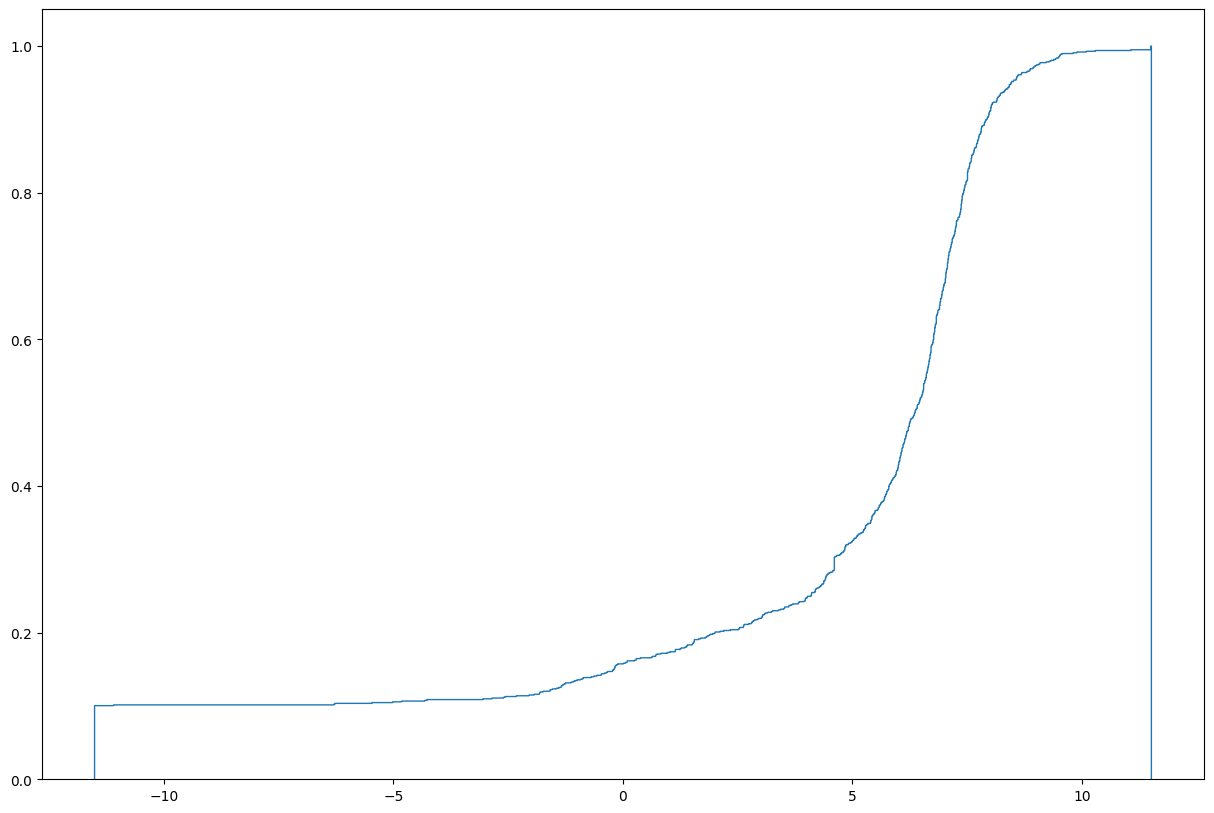

In [21]:
from models import SymbolicGaussianDiffusion, PointNetConfig

pconfig = PointNetConfig(
    embeddingSize=n_embd,
    numberofPoints=numPoints,
    numberofVars=numVars,
    numberofYs=numYs,
)
model = SymbolicGaussianDiffusion(
    tnet_config=pconfig,
    vocab_size=train_dataset.vocab_size,
    max_seq_len=32,
    padding_idx=test_dataset.paddingID,
    max_num_vars=9,
    n_layer=4,
    n_head=4,
    n_embd=n_embd,
    timesteps=timesteps,
    beta_start=0.0001,
    beta_end=0.02,
    set_transformer=True,
).to(device)

model_path = "/content/drive/MyDrive/Colab/STAT946_proj/models/diffusym_cfg/1_var_set_transformer_cfg.pth"
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.eval()
fName="/content/drive/MyDrive/Colab/STAT946_proj/results/diffusym_cfg/ddim_step_1/1_var_set_transformer_cfg.txt"
test_results = run_and_plot(model, fName, test_loader, textTest, train_dataset, device, pconfig)